# Random forest, SVM, XGBOOST example
## import required package

In [1]:
import os
import pandas as pd
import numpy as np


import sklearn
import sklearn.model_selection

from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from xgboost.sklearn import XGBClassifier

from sklearn.preprocessing import StandardScaler
from sklearn import metrics
from sklearn.metrics import roc_curve, classification_report, roc_auc_score

import matplotlib.pyplot as plt
#default plot setting----------------------------------
plt.rc('lines',linewidth=3)
plt.rc('axes',labelsize=20)
plt.rc('xtick',labelsize=20)
plt.rc('ytick',labelsize=20)

plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False

### model evaluation function

In [2]:
def accuracy_calcu(y_test, y_pred):
    accuracy = metrics.accuracy_score(y_test, y_pred)
    rmse = np.sqrt(metrics.mean_squared_error(y_test, y_pred))
    mae = metrics.mean_absolute_error(y_test, y_pred)
    
    CM = metrics.confusion_matrix(y_test, y_pred)
    print('TN:', CM[0,0], 'FP:', CM[0,1], 'FN:', CM[1,0], 'TP:', CM[1,1])
    
    sensitivity = CM[1,1]/ (CM[1,1]+ CM[1,0])
    specificity = CM[0,0] / (CM[0,1] + CM[0,0])
    print('sensitivity:', sensitivity, 'specificity:', specificity)
    return accuracy, rmse, mae

### feature importance

In [3]:
def feature_importance(clf, features, model):
    importances = clf.feature_importances_
    indices = np.argsort(importances)[::-1]
    num_features = len(importances)
     
    #show the feature importance as bar plot
    fig, ax = plt.subplots(1, 1, figsize=(16, 9))
    ax.bar(range(num_features), importances[indices], color="g", align="center")
    plt.xticks(range(num_features), [features[i] for i in indices], rotation='60')
    ax.set_xlim([-1, num_features])
    plt.show()

### AUC_ROC curve

In [4]:
def AUC_ROC(fpr, tpr, auc, label):
    fig, ax = plt.subplots(1,1,figsize=(16, 9),dpi=300)
    ax.plot(fpr, tpr, label='%s (auc = %0.4f)' % (label, auc))
    
    ax.plot([0, 1], [0, 1], color='navy', linestyle='--')
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.legend(loc="lower right", fontsize=20)

# 1. read data

In [24]:
interestDat = pd.read_csv('/content/interest.csv', sep=',', parse_dates = ['Day'])

metaDat = pd.read_csv('/content/meta.csv', sep=',', parse_dates=['time'], usecols=[4,5,6])


feature1 = ['NO. %d Day of search interest'%ii for ii in range(1,8)]
feature2 = ['NO. %d Day of news polarity'%ii for ii in range(1,8)]
features = feature1+feature2

polarity = metaDat[['intro Polarity','title Polarity']]
corr = polarity.corr().iloc[0,1]
print('the Pearson correlation coefficient between intro Polarity and title Polarity is %.3f'%corr)

priceDat = pd.read_csv('/content/price_change.csv',sep=',', parse_dates=['date'])


the Pearson correlation coefficient between intro Polarity and title Polarity is 0.108


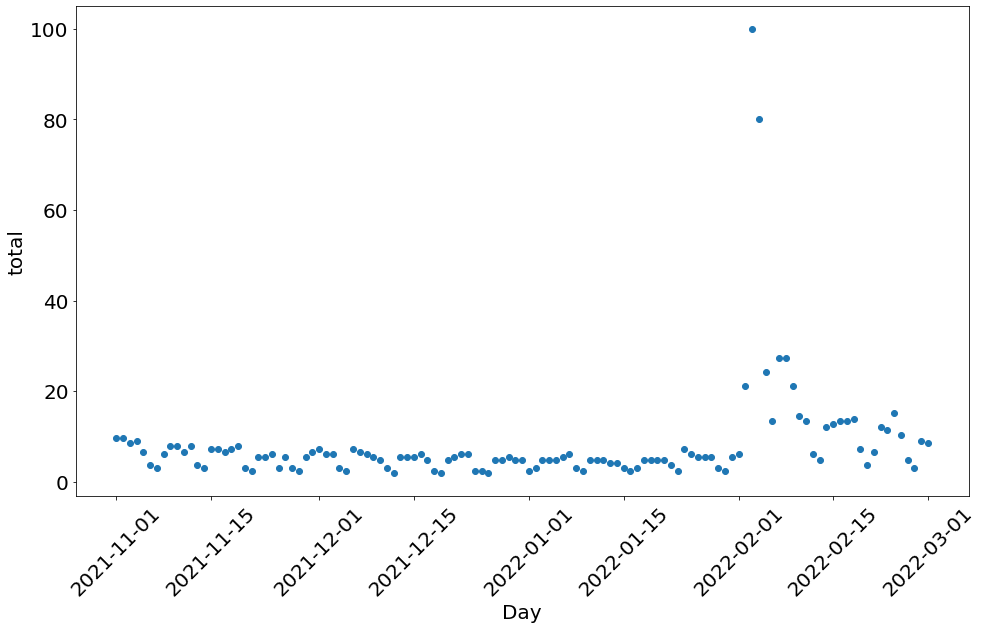

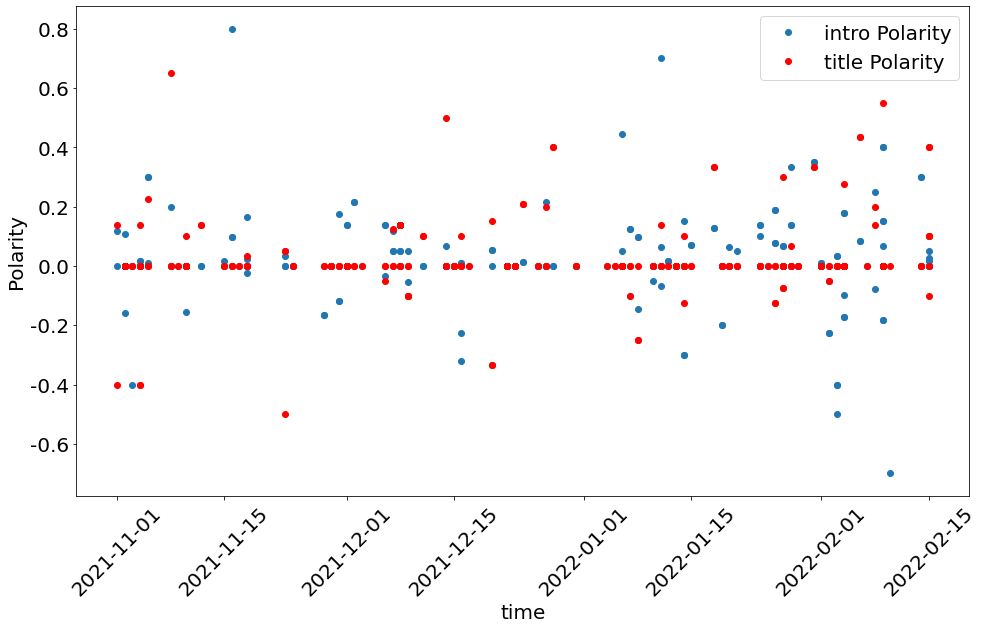

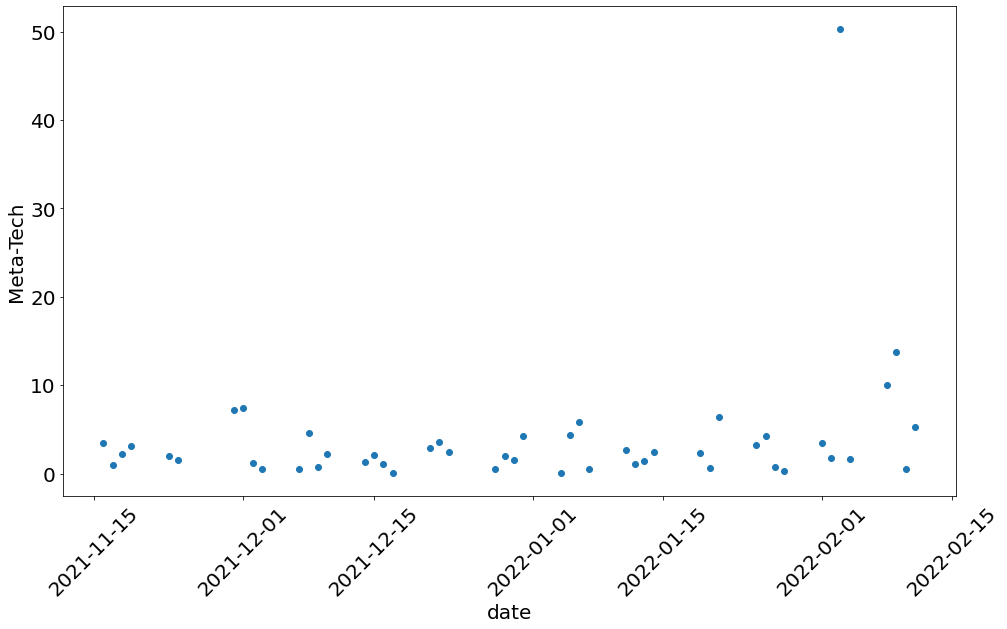

In [25]:
# interpolation for missing value
interestDat = interestDat.interpolate(method='pad')
metaDat = metaDat.interpolate(method='pad')
priceDat = priceDat.interpolate(method='pad')

# figure
# interest
fig, ax = plt.subplots(1,1,figsize=(16,9))
ax.plot_date(interestDat['Day'], interestDat['total'])
ax.set_xlabel('Day')
ax.set_ylabel('total')
ax.xaxis.set_tick_params(rotation=45)

# meta
fig, ax = plt.subplots(1,1,figsize=(16,9))
ax.plot_date(metaDat['time'], metaDat['intro Polarity'], label='intro Polarity')
ax.plot_date(metaDat['time'], metaDat['title Polarity'], label='title Polarity', color='r')
ax.set_xlabel('time')
ax.set_ylabel('Polarity')
ax.set_ylabel('Polarity')
ax.xaxis.set_tick_params(rotation=45)
ax.legend(fontsize=20)


# price
fig, ax = plt.subplots(1,1,figsize=(16,9))
ax.plot_date(priceDat['date'], priceDat['Meta-Tech'])
ax.set_xlabel('date')
ax.set_ylabel('Meta-Tech')
ax.xaxis.set_tick_params(rotation=45)

## 2. data processing

In [36]:
# construct a numpy dataset as required
ii = 0
dat = np.zeros((225, 15))
while ii+7<len(metaDat):
    dat[ii, :7] = metaDat.loc[ii:ii+6, 'intro Polarity']
    dat[ii, 7:] = metaDat.loc[ii:ii+7, 'title Polarity']
    ii += 1

In [34]:
# separate data and label
x, y= np.split(dat,indices_or_sections=(14,),axis=1)
yc = []
for iy in y:
    if iy>=0:
        yc.append(1)
    else:
        yc.append(0)
yc = np.array(yc)

In [35]:
# randomly generate train and test data
X_train, X_test, y_train, y_test = \
    sklearn.model_selection.train_test_split(x, yc, random_state=1, train_size=0.7,test_size=0.3)

In [33]:
# data standardization based on train data
stdScaler = StandardScaler().fit(X_train)
X_train_std = stdScaler.transform(X_train)
X_test_std = stdScaler.transform(X_test) 

# 3. RF

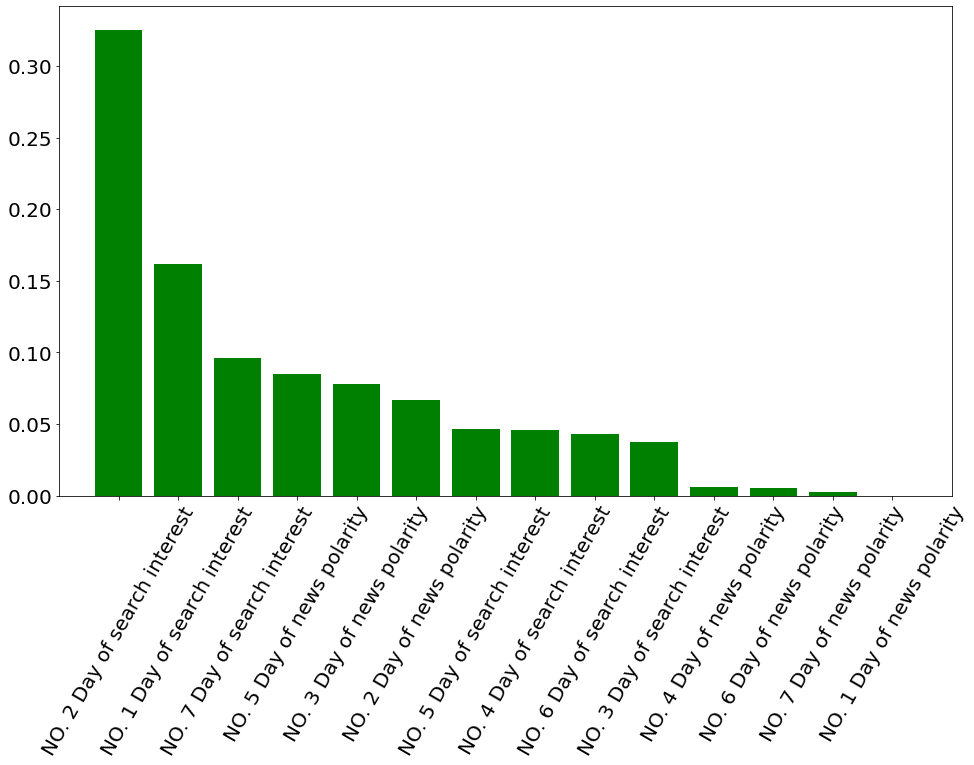

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         5
           1       0.93      1.00      0.96        63

    accuracy                           0.93        68
   macro avg       0.46      0.50      0.48        68
weighted avg       0.86      0.93      0.89        68

TN: 0 FP: 5 FN: 0 TP: 63
sensitivity: 1.0 specificity: 0.0
'RF: accuracy: 0.9264705882352942, RMSE: 0.2711630722733202, mae: 0.07352941176470588, auc: 0.7714285714285715
RF kappa: 0.000 


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [37]:
# build model
RF_classifier = RandomForestClassifier(n_estimators=15, min_samples_leaf=10, 
                                          criterion='gini', random_state=14)
RF_classifier.fit(X_train_std, y_train.ravel())

feature_importance(RF_classifier, features, 'RF')


# test predict
y_test_RF = RF_classifier.predict(X_test_std)
y_pred_RF_prob = RF_classifier.predict_proba(X_test_std)[::, 1]


print(classification_report(y_test, y_test_RF))
auc_RF = roc_auc_score(y_test, y_pred_RF_prob)
accuracy, rmse, mae = accuracy_calcu(y_test, y_test_RF)
print(f''''RF: accuracy: {accuracy}, RMSE: {rmse}, mae: {mae}, auc: {auc_RF}''')
kappa = metrics.cohen_kappa_score(y_test, y_test_RF)
print("RF kappa: %0.3f " % (kappa))

# 4. svm

In [38]:
# build model
SVM_classifier = svm.SVC(C=3, kernel='rbf', gamma=0.1, probability=True) # ovr:一对多策略
SVM_classifier.fit(X_train_std, y_train.ravel()) #ravel函数在降维时默认是行序优先


# test predict
y_test_SVM = SVM_classifier.predict(X_test_std)
y_pred_SVM_prob = SVM_classifier.predict_proba(X_test_std)[::, 1]


print(classification_report(y_test, y_test_SVM))
auc_SVM = roc_auc_score(y_test, y_pred_SVM_prob)
accuracy, rmse, mae = accuracy_calcu(y_test, y_test_SVM)
print(f''''SVM: accuracy: {accuracy}, RMSE: {rmse}, mae: {mae}, auc: {auc_SVM}''')
kappa = metrics.cohen_kappa_score(y_test, y_test_SVM)
print("SVM kappa: %0.3f " % (kappa))

              precision    recall  f1-score   support

           0       1.00      0.40      0.57         5
           1       0.95      1.00      0.98        63

    accuracy                           0.96        68
   macro avg       0.98      0.70      0.77        68
weighted avg       0.96      0.96      0.95        68

TN: 2 FP: 3 FN: 0 TP: 63
sensitivity: 1.0 specificity: 0.4
'SVM: accuracy: 0.9558823529411765, RMSE: 0.21004201260420147, mae: 0.04411764705882353, auc: 0.8412698412698413
SVM kappa: 0.553 


# 5. xgboost

In [39]:
# build model
XGB_classifier = XGBClassifier(n_estimators=50, learning_rate= 0.9, max_depth=10)
XGB_classifier.fit(X_train,y_train)

# test predict
y_test_XGB = XGB_classifier.predict(X_test_std)
y_pred_XGB_prob = XGB_classifier.predict_proba(X_test_std)[::, 1]


print(classification_report(y_test, y_test_XGB))
auc_XGB = roc_auc_score(y_test, y_pred_XGB_prob)
accuracy, rmse, mae = accuracy_calcu(y_test, y_test_XGB)
print(f''''XGB: accuracy: {accuracy}, RMSE: {rmse}, mae: {mae}, auc: {auc_XGB}''')
kappa = metrics.cohen_kappa_score(y_test, y_test_XGB)
print("XGB kappa: %0.3f " % (kappa))


              precision    recall  f1-score   support

           0       0.17      0.20      0.18         5
           1       0.94      0.92      0.93        63

    accuracy                           0.87        68
   macro avg       0.55      0.56      0.55        68
weighted avg       0.88      0.87      0.87        68

TN: 1 FP: 4 FN: 5 TP: 58
sensitivity: 0.9206349206349206 specificity: 0.2
'XGB: accuracy: 0.8676470588235294, RMSE: 0.36380343755449945, mae: 0.1323529411764706, auc: 0.780952380952381
XGB kappa: 0.110 


# 6. AUC-ROC
### 6.1 random forest

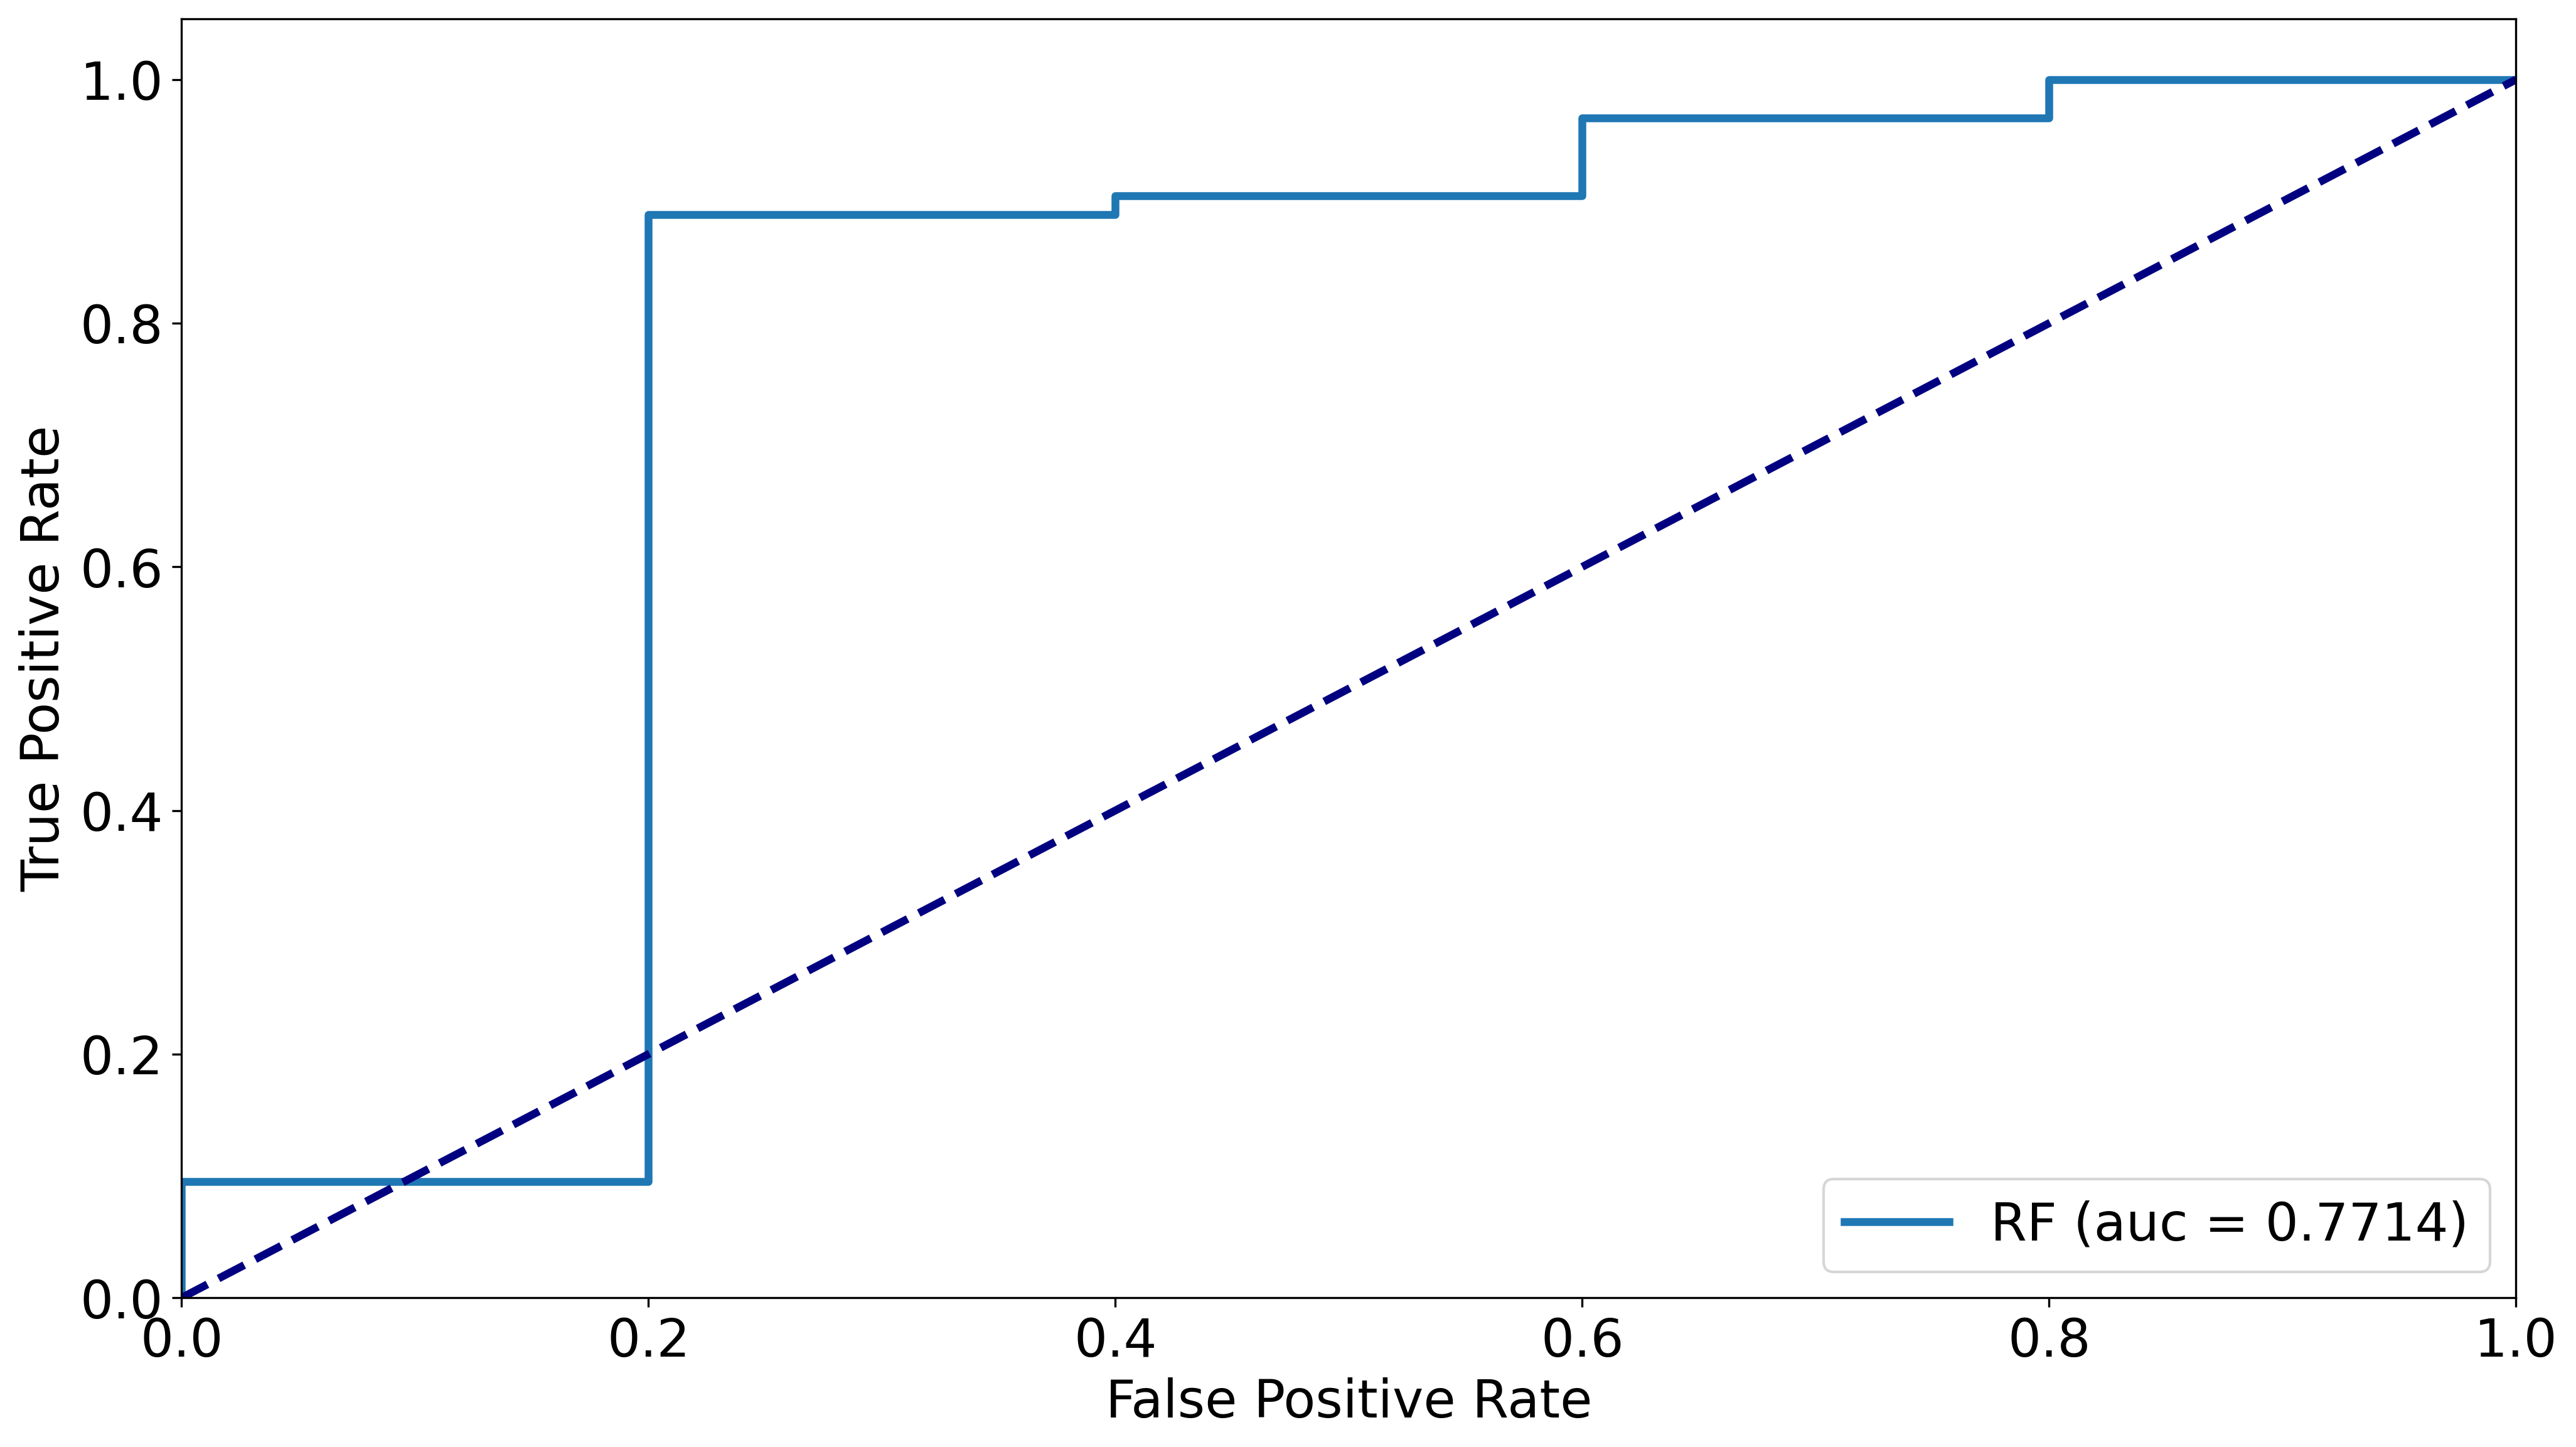

In [40]:
fpr_RF, tpr_RF, thresholds = roc_curve(y_test, y_pred_RF_prob, pos_label=1.0)
AUC_ROC(fpr_RF, tpr_RF, auc_RF, 'RF')

### 6.2 SVM

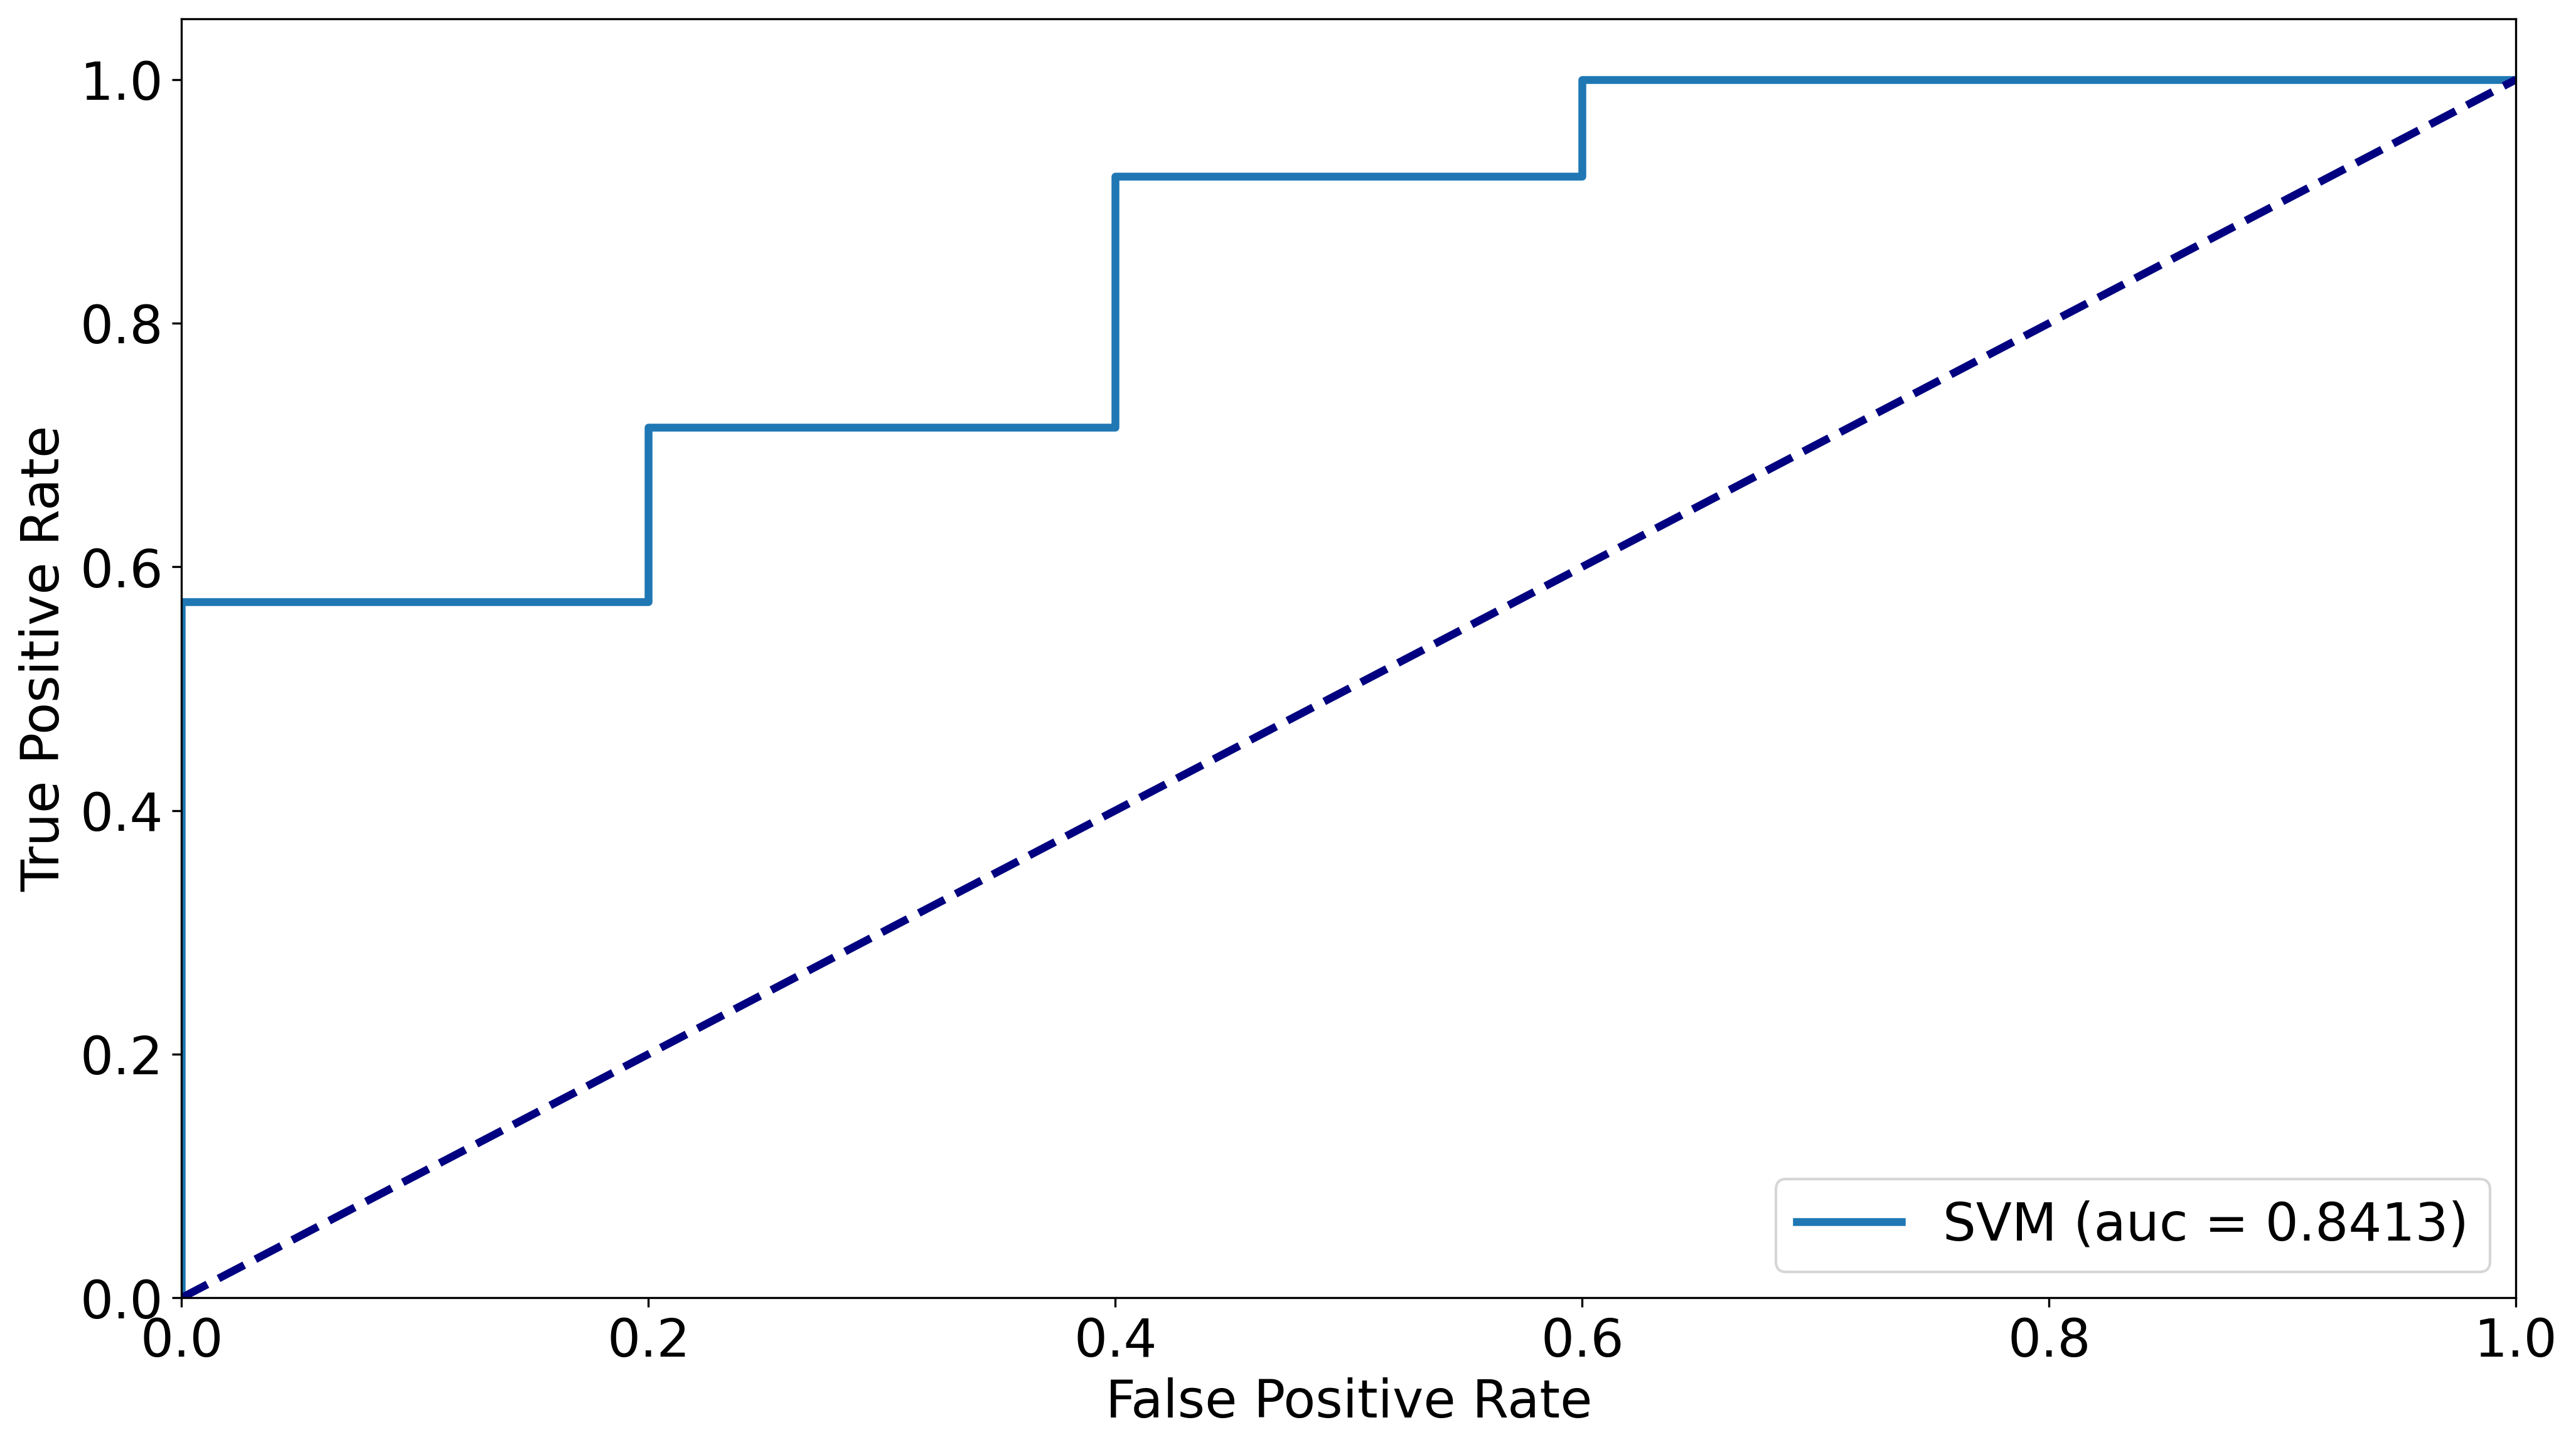

In [41]:
fpr_SVM, tpr_SVM, thresholds = roc_curve(y_test, y_pred_SVM_prob, pos_label=1.0)
AUC_ROC(fpr_SVM, tpr_SVM, auc_SVM, 'SVM')

### 6.3 XGBOOST

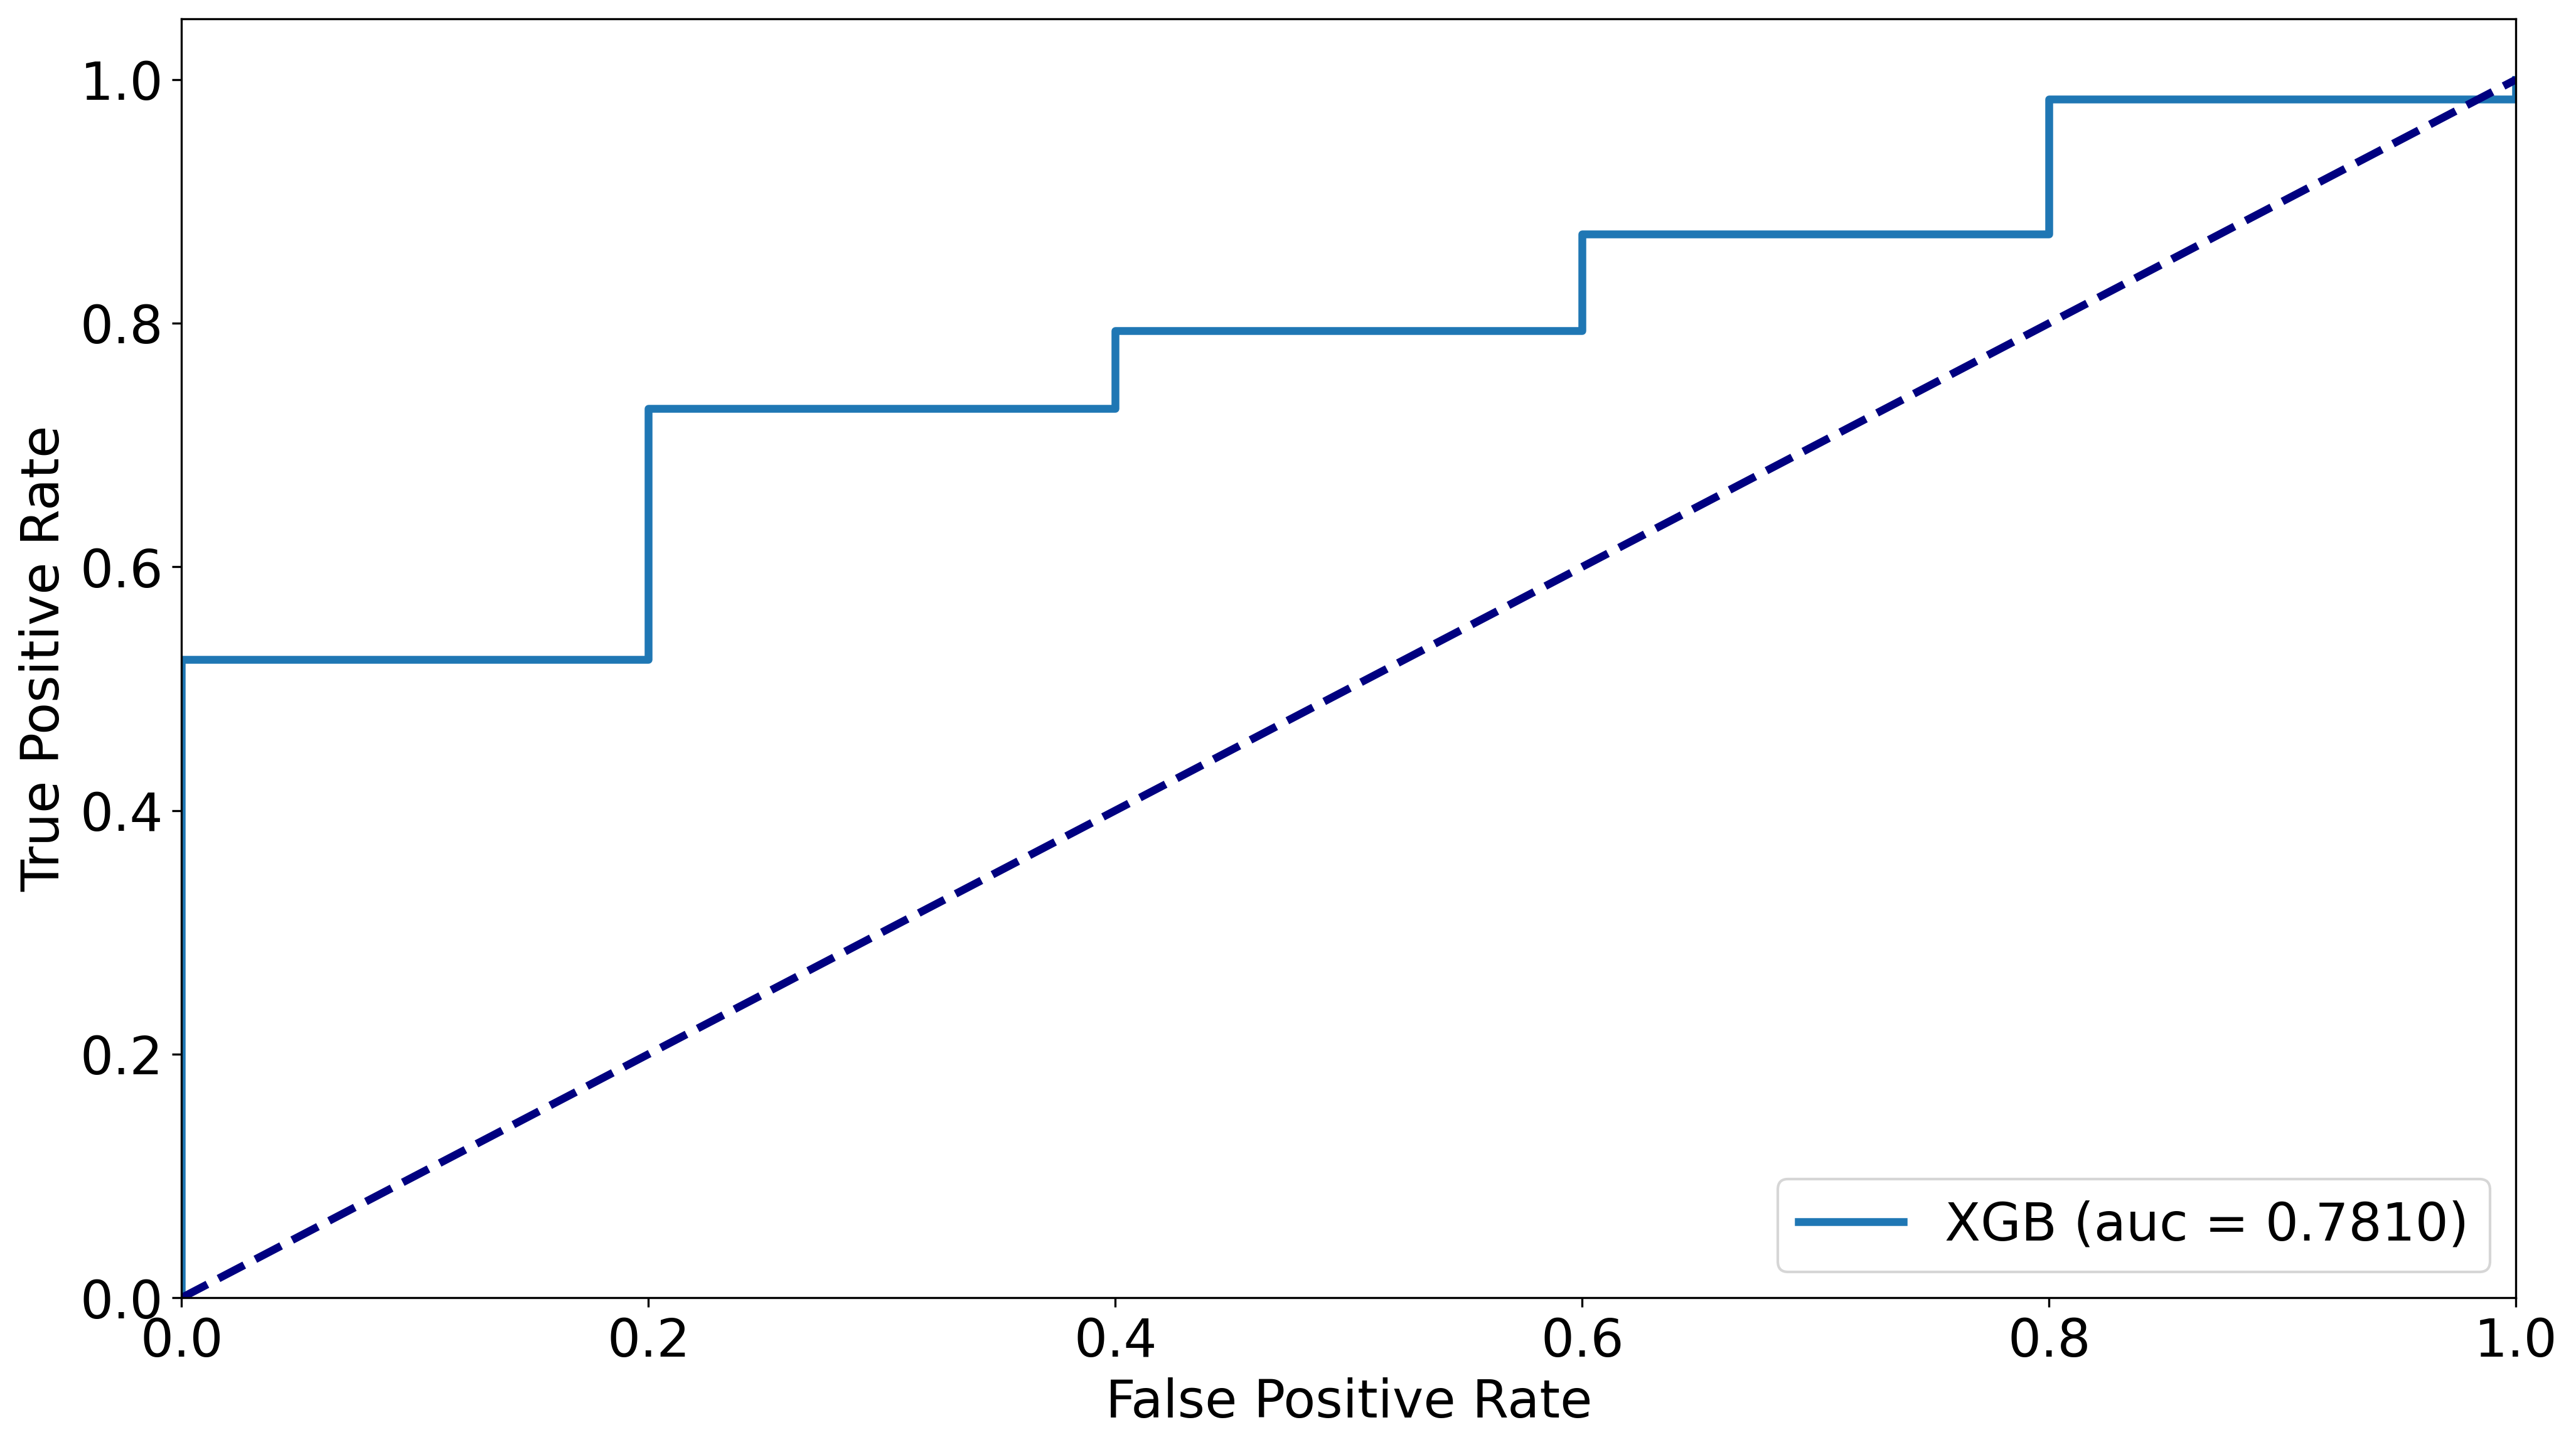

In [42]:
fpr_XGB, tpr_XGB, thresholds = roc_curve(y_test, y_pred_XGB_prob, pos_label=1.0)
AUC_ROC(fpr_XGB, tpr_XGB, auc_XGB, 'XGB')